In [1]:
%cd ..

import torch
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision import transforms
from utils import get_psnr, image_normalization
from alignment.alignment_utils import load_aligned_model, load_deep_jscc

os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

d:\File\Repos\Deep-JSCC-PyTorch


In [16]:
channel = 'AWGN'
# model1_fp = r'alignment\models\upscaled_42.pkl'
model1_fp = r'alignment\models\seed42_v1.pkl'

# model2_fp = r'alignment\models\upscaled_43.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'

aligner_fp = r'alignment\models\aligner_64.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'

snr = 7
test_image_dir = r'demo\0000.jpg'
times = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

file_name = os.path.basename(os.path.dirname(saved))
c = file_name.split('_')[1]
c = int(c)

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

In [18]:
model1 = load_deep_jscc(model1_fp, snr, c, channel)
aligned_model = load_aligned_model(model1_fp, model2_fp, aligner_fp, snr, c, channel)
unaligned_model = load_aligned_model(model1_fp, model2_fp, None, snr, c, channel)

In [19]:
def evaluation_pipeline(model, upscale_factor=8):
    psnr_all = 0.0
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(test_image)
            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(test_image)
            psnr_all += get_psnr(demo_image, gt)

        # prepare image for visualization
        demo_image = image_normalization('normalization')(demo_image)
        demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)  # (C, H, W)
        demo_image = demo_image.numpy()  # (C, H, W)
        demo_image = demo_image.transpose(1, 2, 0)  # convert to (H, W, C) for PIL

        # convert to PIL image and upscale
        pil_image = Image.fromarray((demo_image * 255).astype(np.uint8))
        new_size = (pil_image.width * upscale_factor, pil_image.height * upscale_factor)
        pil_image = pil_image.resize(new_size, Image.NEAREST)  # Use NEAREST or BICUBIC

    # show the upscaled image
    plt.figure(figsize=(new_size[0] / 100, new_size[1] / 100), dpi=100)
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    print("Average PSNR is {:.2f} over {} runs on {}".format(psnr_all.item() / times, times, os.path.basename(test_image_dir)))

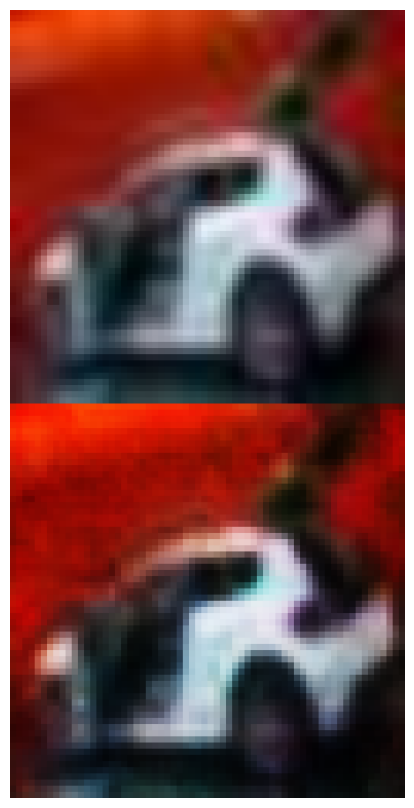

Average PSNR is 23.88 over 10 runs on 0000.jpg


In [20]:
# without semantic mismatch
evaluation_pipeline(model1)

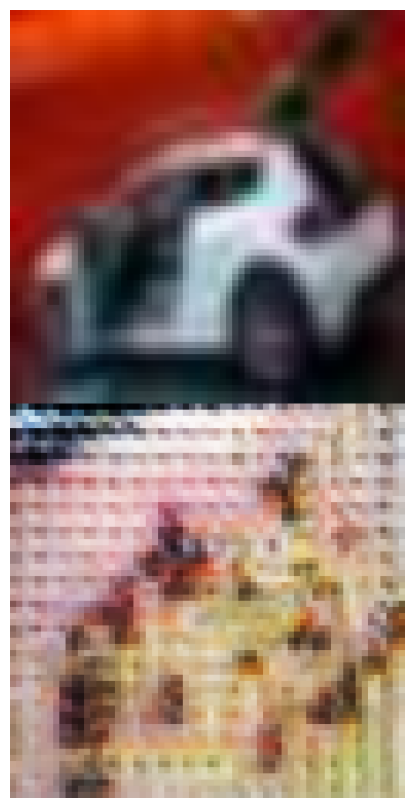

Average PSNR is 6.87 over 10 runs on 0000.jpg


In [21]:
# with semantic mismatch, without aligning
evaluation_pipeline(unaligned_model)

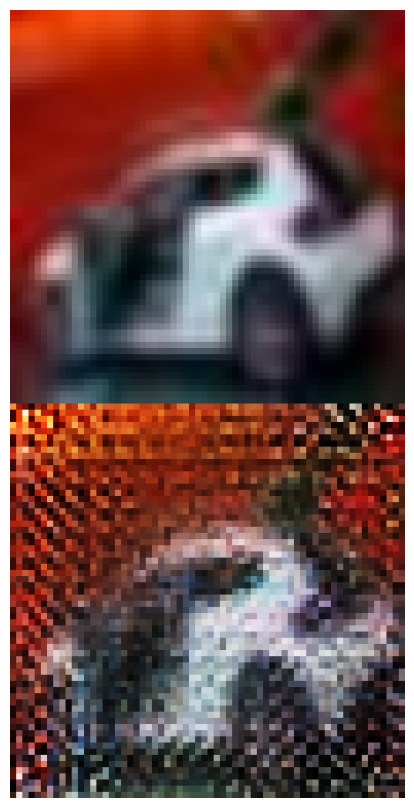

Average PSNR is 17.55 over 10 runs on 0000.jpg


In [22]:
# with semantic mismatch, with aligning
evaluation_pipeline(aligned_model)